In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random
import os
import glob
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import seaborn as sns
%matplotlib inline
from tensorflow.keras.utils import image_dataset_from_directory
import warnings
warnings.filterwarnings('ignore')
import fiftyone as fo
import cv2

In [ ]:
!pip install opencv-python-headless==4.5.4.60 fiftyone

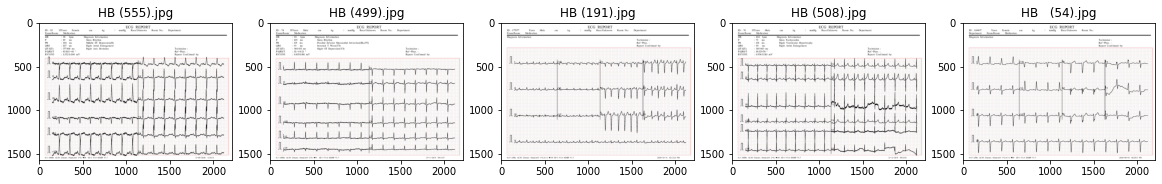

In [3]:
# displaying random five images from one of the folders
plt.figure(figsize=(20,20))
test_folder=r'/content/drive/My Drive/Colab Notebooks/Project/Datasets/Abnormal HB/'
for i in range(5):
  file = random.choice(os.listdir('/content/drive/My Drive/Colab Notebooks/Project/Datasets/Abnormal HB/'))
  image_path= os.path.join('/content/drive/My Drive/Colab Notebooks/Project/Datasets/Abnormal HB/', file)
  img=mpimg.imread(image_path)
  ax=plt.subplot(1,5,i+1)
  ax.title.set_text(file)
  plt.imshow(img)

In [4]:
#setting image dimensions and source folder for loading the dataset
img_width = 20
img_height = 20
img_folder = r'/content/drive/My Drive/Colab Notebooks/Project/Datasets/'

In [5]:
#creating the image dataset and labels from images in the folder
#source folder is the input parameter containing images from different classes
def create_dataset(img_folder):
  img_data_array = []
  class_name = []

  for dir1 in os.listdir(img_folder):
    for file in os.listdir(os.path.join(img_folder, dir1)):
      image_path = os.path.join(img_folder, dir1, file)
      image = cv2.imread(image_path, cv2.COLOR_BGR2RGB) #read image and convert to the right color format
      image = cv2.resize(image, (img_height, img_width), interpolation = cv2.INTER_AREA) #resize the image based on input dimensions
      image = np.array(image) #convert the image to numpy array
      image = image.astype('float32') # normalize the image
      image /= 255
      img_data_array.append(image)
      class_name.append(dir1)
  return img_data_array, class_name
#extract image array and class name
img_data_array, class_name = create_dataset(r'/content/drive/My Drive/Colab Notebooks/Project/Datasets/')

In [6]:
#convert  text labels to numeric codes
#create a dictionary for all unique values for the classes
target_dict = {k: v for v, k in enumerate(np.unique(class_name))}
target_dict

{'Abnormal HB': 0, 'COVID-19': 1, 'HMI': 2, 'MI': 3, 'Normal Person': 4}

In [7]:
#convert the class names to their respectibe numeric values based on the dictionary
target_val = [target_dict[class_name[i]] for i in range(len(class_name))]
print(target_val.count(0)) #Abnormal HB
print(target_val.count(1))#COVID-19
print(target_val.count(2))#HMI
print(target_val.count(3)) #MI
print(target_val.count(4)) #Normal Person


591
250
203
85
859


In [8]:
target_val = np.asarray(target_val)
img_data_array = np.asarray(img_data_array)

In [9]:
len(img_data_array)

1988

In [10]:
#split the dataset into training and test sets
train_images,test_images,train_labels,test_labels = train_test_split(img_data_array,target_val,test_size=0.2,random_state=42)

Text(0.5, 1.0, 'Ground Truth : 4')

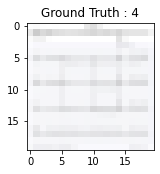

In [11]:
plt.figure(figsize=[5,5])
#Dispay the first image in the training set
plt.subplot(121)
plt.imshow(train_images[0,:,:], cmap = 'gray')
plt.title("Ground Truth : {}".format(train_labels[0]))

Text(0.5, 1.0, 'Ground Truth : 0')

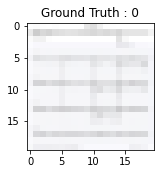

In [12]:
plt.figure(figsize=[5,5])
#Dispay the first image in the test set
plt.subplot(121)
plt.imshow(test_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[0]))

In [13]:
# Visualize a sample (first 25 examples) of the data
def visualize_data():
  fig = plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_images[i], cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_name[train_labels[i]] + "(" + str(train_labels[i]) + ")")

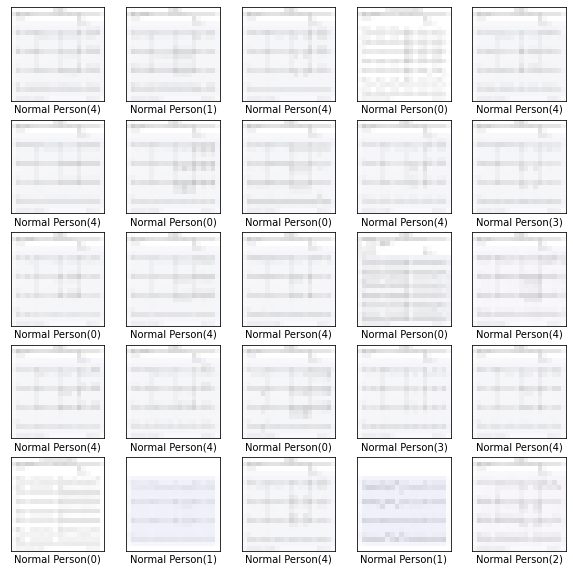

In [14]:
visualize_data()

In [15]:
# Look at the shape of the dataset
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((1590, 20, 20, 3), (1590,), (398, 20, 20, 3), (398,))

Data Preprocessing

In [16]:
#finding and removing duplicates
import fiftyone.zoo as foz
dataset = fo.Dataset.from_dir(r'/content/drive/My Drive/Colab Notebooks/Project/Datasets/', dataset_type=fo.types.ImageClassificationDirectoryTree)

 100% |███████████████| 1988/1988 [1.5s elapsed, 0s remaining, 1.3K samples/s]         


In [26]:
model = foz.load_zoo_model("mobilenet-v2-imagenet-torch")
embeddings = dataset.compute_embeddings(model)
print(embeddings.shape)

 100% |███████████████████| 13/13 [28.2s elapsed, 0s remaining, 0.5 samples/s]    
(13, 1280)


In [27]:
#calculating similarities
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
similarity_matrix = cosine_similarity(embeddings)

print(similarity_matrix.shape)
print(similarity_matrix)

(13, 13)
[[1.         0.91307948 0.89955146 0.75462036 0.73549985 0.77070345
  0.73291333 0.89806686 0.8244782  0.78411838 0.86553812 0.83805555
  0.72639833]
 [0.91307948 1.         0.91900076 0.75169827 0.75977746 0.75672687
  0.77190019 0.88346033 0.86840943 0.80353896 0.83418766 0.80190647
  0.71744808]
 [0.89955146 0.91900076 1.         0.73014027 0.74252264 0.73556452
  0.76807557 0.91055692 0.90056163 0.77947869 0.80200067 0.77582631
  0.69238159]
 [0.75462036 0.75169827 0.73014027 1.         0.84620002 0.91595205
  0.8039564  0.78270345 0.71131352 0.73533039 0.73750017 0.76845801
  0.87543285]
 [0.73549985 0.75977746 0.74252264 0.84620002 1.         0.90620729
  0.91982394 0.77848559 0.79502156 0.69407389 0.74686097 0.70542984
  0.88775002]
 [0.77070345 0.75672687 0.73556452 0.91595205 0.90620729 1.
  0.85716939 0.78741717 0.72474114 0.7247536  0.78049882 0.74795725
  0.91685169]
 [0.73291333 0.77190019 0.76807557 0.8039564  0.91982394 0.85716939
  1.         0.74170179 0.79490

In [28]:
n = len(similarity_matrix)
similarity_matrix = similarity_matrix - np.identity(n)

In [29]:
#visualize and remove duplicates
id_map = [s.id for s in dataset.select_fields(["id"])]
for idx, sample in enumerate(dataset):
  sample["max_similarity"] = similarity_matrix[idx].max()
  sample.save()

In [30]:
from fiftyone import ViewField as F
dataset.match(F("max_similarity")>0.92)

Dataset:     2022.02.13.04.59.57
Media type:  image
Num samples: 0
Tags:        []
Sample fields:
    id:             fiftyone.core.fields.ObjectIdField
    filepath:       fiftyone.core.fields.StringField
    tags:           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    max_similarity: fiftyone.core.fields.FloatField
View stages:
    1. Match(filter={'$expr': {'$gt': [...]}})

In [31]:
id_map = [s.id for s in dataset.select_fields(["id"])]
thresh = 0.92
samples_to_remove = set()
samples_to_keep = set()
for idx, sample in enumerate(dataset):
  if sample.id not in samples_to_remove:
    # Keep the first instance of two duplicates
    samples_to_keep.add(sample.id)
    dup_idxs = np.where(similarity_matrix[idx] > thresh)[0]
    for dup in dup_idxs:
      # We kept the first instance so remove all other duplicates
      samples_to_remove.add(id_map[dup])
      if len(dup_idxs) > 0:
        sample.tags.append("has_duplicates")
        sample.save()
      else:
        sample.tags.append("duplicate")
        sample.save()
print(len(samples_to_remove) + len(samples_to_keep))
#  remove the samples from the dataset entirely
dataset.remove_samples(list(samples_to_remove))

13


In [32]:
#samples have duplicates both in the test and train split and how many are labeled differently.
view = dataset.match_tags(["has_duplicates","duplicate"])
thresh = 0.92
for idx, sample in enumerate(dataset):
  if sample.id in view:
    dup_idxs = np.where(similarity_matrix[idx] > thresh)[0]
    dup_splits = []
    dup_labels = {sample.ground_truth.label}
    for dup in dup_idxs:
      dup_sample = dataset[id_map[dup]]
      dup_split = "test" if "test" in dup_sample.tags else "train"
      dup_splits.append(dup_split)
      dup_labels.add(dup_sample.ground_truth.label)
      sample["dup_splits"] = dup_splits
      sample["dup_labels"] = list(dup_labels)
      sample.save()

In [33]:
view.first()

<SampleView: {
    'id': '6208904d3fe33d2aa28660ba',
    'media_type': 'image',
    'filepath': '/content/drive/My Drive/Colab Notebooks/Project/Datasets/Abnormal HB/HB   (1).jpg',
    'tags': BaseList([
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_duplicates',
        'has_dup

In [39]:
#Compute how many of the duplicates exist in BOTH the train and test split.
from fiftyone import ViewField as F
train_w_test_dups = len(view.match(F("tags").contains("train")) and view.match(F("dup_splits").contains("test")))
test_w_train_dups = len(view.match(F("tags").contains("test"))and view.match(F("dup_splits").contains("train")))
print(train_w_test_dups + test_w_train_dups)

0


In [40]:
#compute how many duplicates are labeled differently.
label_mismatches = len(view.match(F("dup_labels").length() > 1))
print(label_mismatches)

0


In [42]:
train_images= train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') /255.0

In [43]:
# Check at the shape of our data
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((1590, 20, 20, 3), (1590,), (398, 20, 20, 3), (398,))

In [44]:
#change labels from categorical to one hot encoding
from tensorflow.keras.utils import to_categorical
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

In [45]:
# Display change of categorical label to one hot encoded label
print("Categorical Label", train_labels[1])
print("One-Hot Encoded Label", train_labels_one_hot[1])

Categorical Label 1
One-Hot Encoded Label [0. 1. 0. 0. 0.]


In [46]:
# Split training data into train and validation sets 
train_images,valid_images,train_label,valid_label = train_test_split(train_images, train_labels_one_hot,
test_size=0.2, random_state=13)

In [47]:
# Final check at the shape of our data
train_images.shape, train_label.shape, valid_images.shape, valid_label.shape

((1272, 20, 20, 3), (1272, 5), (318, 20, 20, 3), (318, 5))

Define the Model 

In [133]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv3D, MaxPooling3D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [166]:
#define the model
#model =  Sequential()
#model.add(Conv2D(filters = 16, kernel_size = (3,3), activation= "relu", padding = "same", input_shape = (20, 20, 3)))
#model.add(MaxPooling2D(pool_size = (2,2), padding = "same"))

#model.add(Conv2D(filters = 32, kernel_size = (3,3), activation= "relu", padding = "same"))
#model.add(MaxPooling2D(pool_size = (2,2), padding = "same"))

#model.add(Conv2D(filters = 32, kernel_size = (3,3), activation= "relu", padding = "same"))
#model.add(MaxPooling2D(pool_size = (2,2), padding = "same"))

#model.add(Conv2D(filters = 32, kernel_size = (3,3), activation= "relu", padding = "same"))
#model.add(MaxPooling2D(pool_size = (2,2), padding = "same"))

#model.add(Conv2D(filters = 64, kernel_size = (3,3), activation= "relu", padding = "same"))
#model.add(MaxPooling2D(pool_size = (2,2), padding = "same"))

#model.add(Dropout(0.2))
#model.add(Flatten())
#model.add(Dense(128, activation = "relu"))
#model.add(Dense(64, activation = "relu"))
#model.add(Dense(32, activation = "relu"))
#model.add(Dense(5, activation = "softmax"))